In [4]:
import pandas
import geopandas

In [5]:
df = geopandas.read_parquet("../_products/get/bronchiolitis_points.parquet")

In [6]:
df.head()

,hc,ingreso,egreso,se,edad,domicilio_definitivo,es_reinternacion,latitud,longitud,geometry
0,143367,2017-01-06,2017-01-09,1.0,0.63,Manuel Castro 1230,False,-42.759311,-65.055118,POINT (-65.05512 -42.75931)
1,143597,2017-01-19,2017-01-21,3.0,0.70,Cholila 1311,False,-42.760486,-65.057645,POINT (-65.05765 -42.76049)
2,144173,2017-02-22,2017-02-23,8.0,0.33,Luis Federico Leloir 820,False,-42.786004,-65.071097,POINT (-65.07110 -42.78600)
3,144546,2017-03-27,2017-04-01,13.0,4.00,Mitre 41,False,-42.765109,-65.037430,POINT (-65.03743 -42.76511)
4,144189,2017-03-29,2017-04-01,13.0,1.00,El Hoyo 1310,False,-42.758420,-65.062481,POINT (-65.06248 -42.75842)


In [7]:
len(df)

114

<AxesSubplot:>

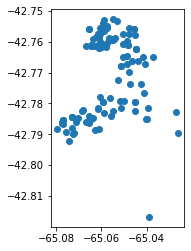

In [8]:
df.plot()

In [9]:
root_path = '/home/lmorales/work/pipelines/pi-bronquiolitis'
bronchiolitis_cases_file_path = '/input-data/IRAB O2 2017 18 19 20 O31.csv'
adresses_file_path = '/input-data/domicilio_lat_long_corregido.csv'

In [11]:
df_casos = pandas.read_csv(f"{root_path}/{bronchiolitis_cases_file_path}")

In [12]:
df_domicilios = pandas.read_csv(f"{root_path}/{adresses_file_path}")

In [13]:
df_casos.head()

,HC,FN,MESES,Edad,Vaginal,Cesarea,Sexo,SE,INGRESO,EGRESO,...,Virus,Domicilio,ALTERNATIVA,Domicilio definitivo,Unnamed: 17,Barrio,Circunscripción,Sector,Unnamed: 21,Nombre del Barrio
0,143367,2016-12-18,19 días,0.63,NaN,NaN,NaN,1.0,2017-01-06,2017-01-09,...,NE,B° Comercio IV casa 3,Manuel Castro 1230,Manuel Castro 1230,NaN,N27,1.0,10.0,NaN,SEC
1,143597,2016-12-29,21 días,0.70,NaN,NaN,NaN,3.0,2017-01-19,2017-01-21,...,NE,Cholila 1311,Rada Tilly 1310,Cholila 1311,NaN,N18,1.0,12.0,NaN,Pujol
2,144173,2017-02-10,10 días,0.33,NaN,NaN,NaN,8.0,2017-02-22,2017-02-23,...,NE,B Pte. Perón M461 L25,Luis Federico Leloir 820,Luis Federico Leloir 820,NaN,O35,3.0,7.0,NaN,Pte. Perón
3,144546,2016-11-14,4,4.00,NaN,NaN,NaN,13.0,2017-03-27,2017-04-01,...,NE,Mitre 41 Dpto 6,NaN,Mitre 41,NaN,E9,1.0,7.0,NaN,Parry Madryn
4,144189,2017-02-18,1,1.00,NaN,NaN,NaN,13.0,2017-03-29,2017-04-01,...,NE,Che Guevara 1628,El Hoyo 1310,El Hoyo 1310,NaN,N18,1.0,12.0,NaN,Pujol


In [14]:
df_domicilios.head()

,Domicilio definitivo,Latitud,Longitud
0,Manuel Castro 1230,-42.759311,-65.055118
1,Cholila 1311,-42.760486,-65.057645
2,Luis Federico Leloir 820,-42.786004,-65.071097
3,Mitre 41,-42.765109,-65.037430
4,El Hoyo 1310,-42.758420,-65.062481


In [15]:
df_cols = ['HC', 'INGRESO', 'EGRESO', 'SE', 'Edad', 'Domicilio definitivo']
df = df_casos[df_cols]

## eliminar aquellos que no tienen numero de historia clinica:
df = df.dropna(subset=['HC'])
## primero ordenamos por fecha de ingreso
df = df.sort_values(by='INGRESO')
## después de ordenar, si se repite el nro de historia clinica, es reinternación:
df['es_reinternacion'] = df['HC'].duplicated()
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.reset_index(drop=True)


## rename columns (lowercase):
df_domicilios = df_domicilios.rename(
    columns={
        column: column.lower().replace(' ', '_')
        for column
        in df_domicilios.columns
    }
)

## sort from north to south, east to west:
LAT_COLUMN = 'latitud'
LNG_COLUMN = 'longitud'
sorted_index_values = (df_domicilios[LAT_COLUMN] ** 2 + df_domicilios[LNG_COLUMN] **2).sort_values().index
df_domicilios = df_domicilios.iloc[sorted_index_values]

## delete duplicates:
df_domicilios = df_domicilios.drop_duplicates()
df_domicilios = df_domicilios.reset_index(drop=True)

In [16]:
#
# C: Combine
output_df = pandas.merge(
    df,
    df_domicilios,
    on='domicilio_definitivo',
)

In [18]:
len(output_df)

114

In [24]:
len(output_df[output_df['hc'].duplicated()])

14

In [23]:
len(output_df[output_df['hc'].duplicated()]['hc'].unique())

14

In [25]:
hcs_reinternaciones = [
    "143314-1",
    "144266-5",
    "143314-1",
    "144545-9",
    "144719-7",
    "144264-4",
    "145764-2",
    "144668-6",
    "145764-2",
    "142687-3",
    "142687-3",
    "144264-4",
    "144266-5",
    "144668-6",
    "144179-7",
    "146152-8",
    "146152-8",
    "144545-9",
    "146865-10",
    "146865-10",
]

In [26]:
hcs_reinternaciones_unicas = set(hcs_reinternaciones)

In [28]:
len(hcs_reinternaciones_unicas)

11

In [29]:
len(hcs_reinternaciones)

20

In [31]:
esta_en_ids_unicos = output_df['hc'].isin(hcs_reinternaciones_unicas)
es_una_reinternacion = output_df['es_reinternacion'] == True
output_df[(~esta_en_ids_unicos) & es_una_reinternacion]

,hc,ingreso,egreso,se,edad,domicilio_definitivo,es_reinternacion,latitud,longitud
82,144586,2017-08-22,2017-08-29,34.0,5.0,Tecka 2050,True,-42.758968,-65.063648
83,144874,2017-08-25,2017-08-29,34.0,4.0,Gualjaina 1410,True,-42.761319,-65.061313
97,145769,2017-10-10,2017-10-12,41.0,4.0,Lago Puelo 1476,True,-42.762029,-65.061269
100,143367,2017-10-28,2017-10-31,43.0,11.0,Vittorio Martinelli 1230,True,-42.758846,-65.053807


In [33]:
output_df[(~esta_en_ids_unicos) & es_una_reinternacion]['hc'].values

array(['144586', '144874', '145769', '143367'], dtype=object)

In [34]:
output_df[output_df['hc'].isin(['144586', '144874', '145769', '143367'])]

,hc,ingreso,egreso,se,edad,domicilio_definitivo,es_reinternacion,latitud,longitud
0,143367,2017-01-06,2017-01-09,1.0,0.63,Manuel Castro 1230,False,-42.759311,-65.055118
12,144874,2017-05-19,2017-05-20,20.0,1.00,Río Mayo 1510,False,-42.761389,-65.064638
38,144586,2017-07-13,2017-07-18,28.0,3.00,Simón de Alcazabar 440,False,-42.766273,-65.046370
77,145769,2017-08-15,2017-08-22,33.0,1.00,Rada Tilly 1280,False,-42.758078,-65.061463
82,144586,2017-08-22,2017-08-29,34.0,5.00,Tecka 2050,True,-42.758968,-65.063648
83,144874,2017-08-25,2017-08-29,34.0,4.00,Gualjaina 1410,True,-42.761319,-65.061313
97,145769,2017-10-10,2017-10-12,41.0,4.00,Lago Puelo 1476,True,-42.762029,-65.061269
100,143367,2017-10-28,2017-10-31,43.0,11.00,Vittorio Martinelli 1230,True,-42.758846,-65.053807


In [ ]:
144586 # Simón de Alcazabar 440 x Tecka 2050

144874 # cambio de domicilio (pareceria reinternación) -> usar Río Mayo 1510 en lugar de Gualjaina 1410

145769 # usar Rada Tilly 1280 en lugar de Lago Puelo 1476

143367 # Manuel Castro 1230 en lugar de Vittorio Martinelli 1230

In [42]:
df_domicilios.loc[df_domicilios['domicilio_definitivo'] == "Simón de Alcazabar 440", ]

,domicilio_definitivo,latitud,longitud
19,Simón de Alcazabar 440,-42.766273,-65.04637


In [47]:
df.loc[df['domicilio_definitivo'] == "Tecka 2050", "domicilio_definitivo"] = "Simón de Alcazabar 440"

print(df.loc[df['domicilio_definitivo'] == "Gualjaina 1410",])

df.loc[df['domicilio_definitivo'] == "Gualjaina 1410", "domicilio_definitivo"] = "Río Mayo 1510"

print(df.loc[df['domicilio_definitivo'] == "Gualjaina 1410",])

print(df.loc[df['domicilio_definitivo'] == "Lago Puelo 1476",])

df.loc[df['domicilio_definitivo'] == "Lago Puelo 1476", "domicilio_definitivo"] = "Rada Tilly 1280"

print(df.loc[df['domicilio_definitivo'] == "Lago Puelo 1476",])

print(df.loc[df['domicilio_definitivo'] == "Vittorio Martinelli 1230",])

df.loc[df['domicilio_definitivo'] == "Vittorio Martinelli 1230", "domicilio_definitivo"] = "Manuel Castro 1230"

print(len(df.loc[df['domicilio_definitivo'] == "Vittorio Martinelli 1230",]))

In [54]:
output_df[output_df['hc'] == "143314-1"]

,hc,ingreso,egreso,se,edad,domicilio_definitivo,es_reinternacion,latitud,longitud
5,143314-1,2017-04-15,2017-04-18,15.0,4.0,Esteban Williams 812,False,-42.783971,-65.065442
9,143314-1,2017-05-02,2017-05-16,18.0,4.0,Ruperto Gimenez 720,True,-42.784649,-65.070284


In [55]:
output_df[output_df['hc'] == "145764-2"]

,hc,ingreso,egreso,se,edad,domicilio_definitivo,es_reinternacion,latitud,longitud
25,145764-2,2017-06-26,2017-06-28,26.0,0.6,Trevellin 1510,False,-42.761119,-65.061504
40,145764-2,2017-07-14,2017-07-16,28.0,1.0,Rio Pico 1710,True,-42.757520,-65.060710
